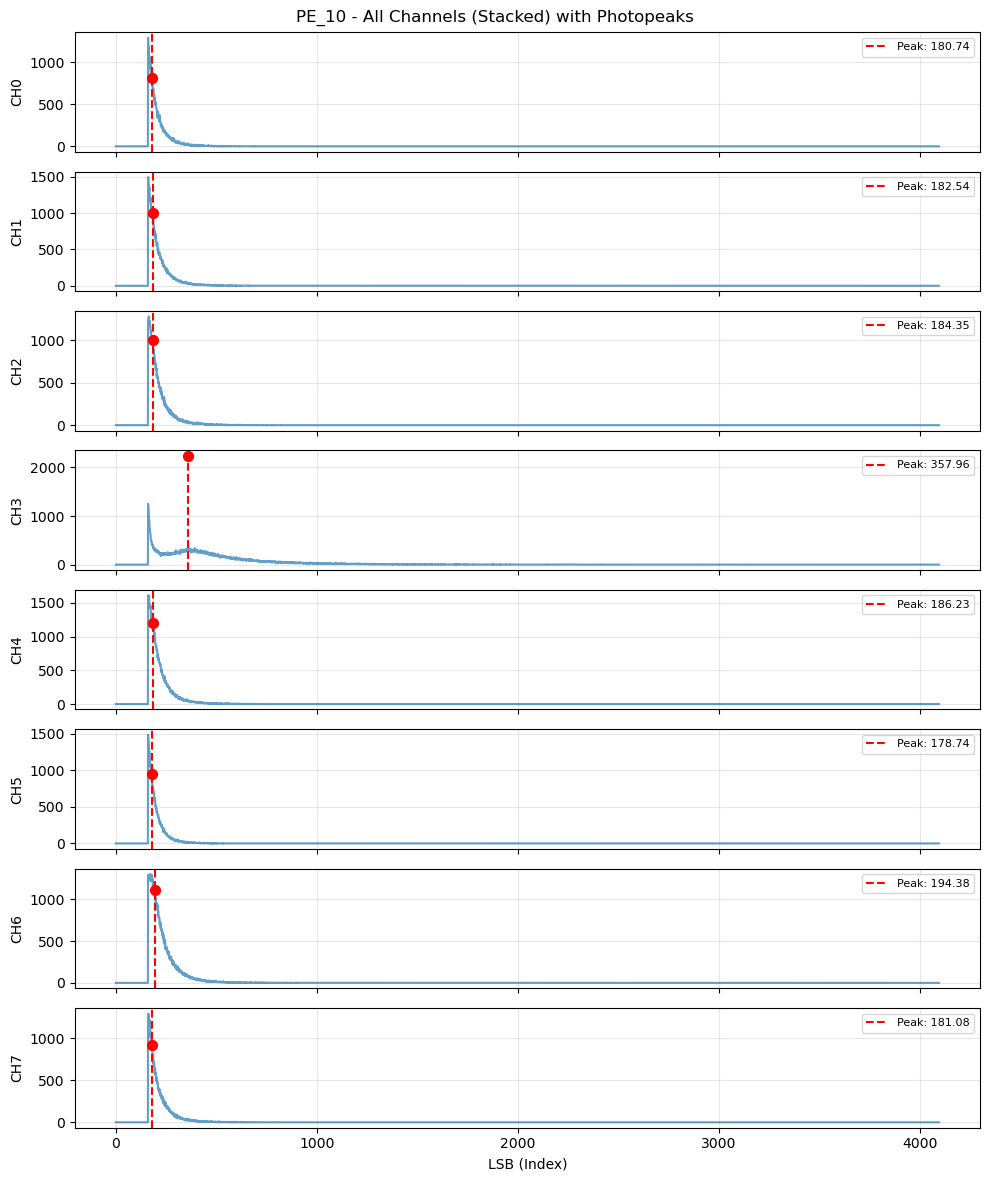


=== PE_10 - Peak Positions ===
CH0: Peak at 180.74 (Amplitude: 809.15, σ: 20.40) [Gaussian fit]
CH1: Peak at 182.54 (Amplitude: 1007.63, σ: 21.63) [Gaussian fit]
CH2: Peak at 184.35 (Amplitude: 1000.28, σ: 22.47) [Gaussian fit]
CH3: Peak at 357.96 (Amplitude: 2238.77, σ: 626.65) [Gaussian fit]
CH4: Peak at 186.23 (Amplitude: 1206.88, σ: 24.26) [Gaussian fit]
CH5: Peak at 178.74 (Amplitude: 950.74, σ: 18.59) [Gaussian fit]
CH6: Peak at 194.38 (Amplitude: 1119.10, σ: 30.18) [Gaussian fit]
CH7: Peak at 181.08 (Amplitude: 918.83, σ: 20.39) [Gaussian fit]


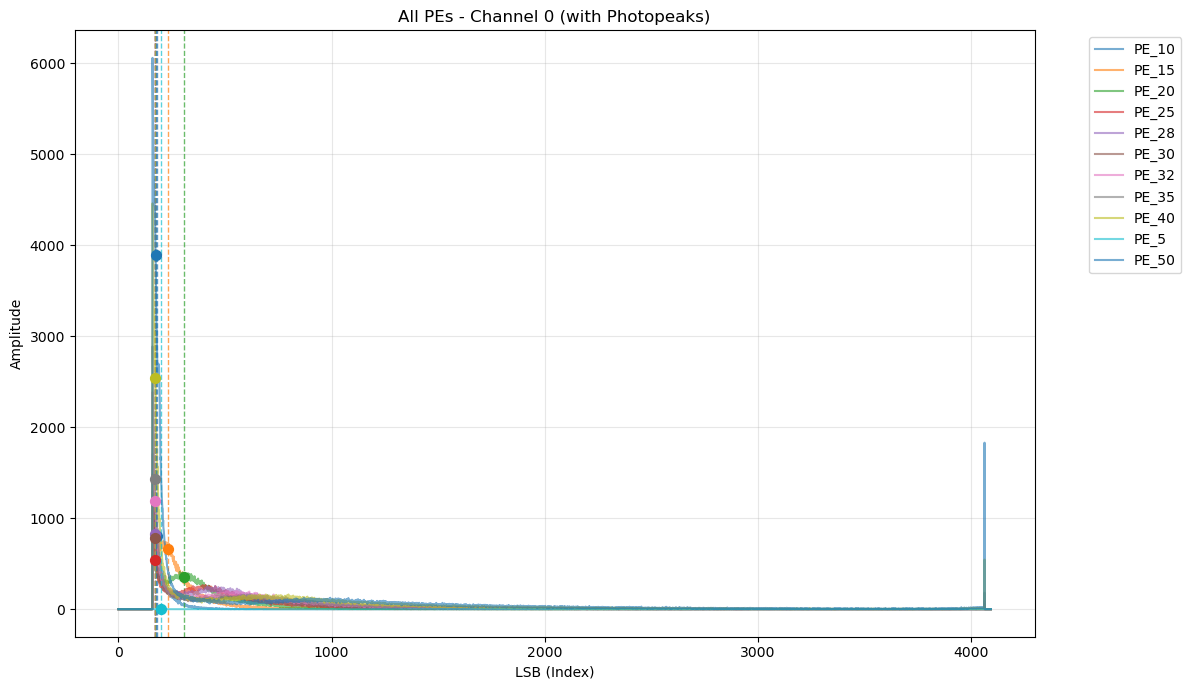


=== All PEs - Channel 0 Peak Positions ===
PE_10: Peak at 180.74 (Amplitude: 809.15, σ: 20.40) [Gaussian fit]
PE_15: Peak at 231.67 (Amplitude: 664.95, σ: 53.97) [Gaussian fit]
PE_20: Peak at 306.31 (Amplitude: 353.68, σ: 114.48) [Gaussian fit]
PE_25: Peak at 172.10 (Amplitude: 541.33, σ: 11.12) [Gaussian fit]
PE_28: Peak at 171.84 (Amplitude: 822.61, σ: -11.53) [Gaussian fit]
PE_30: Peak at 172.54 (Amplitude: 779.68, σ: -12.24) [Gaussian fit]
PE_32: Peak at 171.94 (Amplitude: 1187.81, σ: -12.13) [Gaussian fit]
PE_35: Peak at 171.74 (Amplitude: 1427.72, σ: -12.55) [Gaussian fit]
PE_40: Peak at 172.27 (Amplitude: 2542.43, σ: 12.85) [Gaussian fit]
PE_5: Peak at 201.00 (Amplitude: 0.05, σ: 9.46) [Gaussian fit]
PE_50: Peak at 175.97 (Amplitude: 3887.97, σ: 15.59) [Gaussian fit]

=== Summary for Channel 0 ===
Processed 11 PE folders
Mean peak position: 193.47
Std deviation: 39.84
Peak range: 171.74 to 306.31

Plots saved: single_pe_all_channels.png and all_pes_ch0.png


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Helper Functions
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def smooth_data(y, window=51, poly=3):
    """Apply Savitzky-Golay smoothing filter"""
    if window % 2 == 0:
        window += 1
    if window > len(y):
        window = len(y) - 1 if len(y) % 2 == 0 else len(y)
    return savgol_filter(y, window_length=window, polyorder=poly)

def gaussian(x, a, mu, sigma, c):
    """Gaussian + constant background"""
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2) + c

def find_peak_gaussian(x, y, window=500):
    """
    Find photopeak using Gaussian fit
    Returns: (peak_position, peak_amplitude, sigma, fit_success)
    """
    try:
        # Smooth the data
        y_smooth = smooth_data(y)
        
        # Find peak and select fitting region
        peak_idx = np.argmax(y_smooth)
        fit_start = max(0, peak_idx - window)
        fit_end = min(len(y_smooth), peak_idx + window)
        
        x_fit = x[fit_start:fit_end]
        y_fit = y_smooth[fit_start:fit_end]
        
        # Initial guesses
        initial_guess = [y_smooth[peak_idx], x[peak_idx], 100, np.min(y_fit)]
        
        # Fit Gaussian
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        a_fit, mu_fit, sigma_fit, c_fit = popt
        
        return mu_fit, a_fit, sigma_fit, True
    except:
        # Fallback to simple max if fitting fails
        peak_idx = np.argmax(y)
        return x[peak_idx], y[peak_idx], 0, False

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get all PE folders
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pe_folders = sorted([d for d in Path('.').iterdir() if d.is_dir() and d.name.startswith('PE_')])

if len(pe_folders) == 0:
    print("No PE folders found!")
    exit()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot 1: Single PE across all channels (stacked) with peak markers
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pe_folder = pe_folders[0]  # Use first PE folder
fig, axes = plt.subplots(8, 1, figsize=(10, 12), sharex=True)
fig.suptitle(f'{pe_folder.name} - All Channels (Stacked) with Photopeaks')

peak_results_single = {}

for ch in range(8):
    df = pd.read_csv(pe_folder / f'amplitude_ch{ch}.csv')
    x = df.index.values  # Use index as x-axis (LSB)
    y = df.iloc[:, 0].values  # First column is amplitude/frequency
    
    # Find peak
    peak_pos, peak_amp, sigma, fit_success = find_peak_gaussian(x, y)
    peak_results_single[ch] = (peak_pos, peak_amp, sigma, fit_success)
    
    # Plot
    axes[ch].plot(x, y, alpha=0.7)
    axes[ch].axvline(peak_pos, color='r', linestyle='--', linewidth=1.5, 
                     label=f'Peak: {peak_pos:.2f}')
    axes[ch].scatter([peak_pos], [peak_amp], color='r', s=50, zorder=5)
    axes[ch].set_ylabel(f'CH{ch}')
    axes[ch].legend(loc='upper right', fontsize=8)
    axes[ch].grid(True, alpha=0.3)

axes[-1].set_xlabel('LSB (Index)')
plt.tight_layout()
plt.savefig('single_pe_all_channels.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n=== {pe_folder.name} - Peak Positions ===")
for ch, (pos, amp, sigma, success) in peak_results_single.items():
    fit_type = "Gaussian fit" if success else "Simple max"
    print(f"CH{ch}: Peak at {pos:.2f} (Amplitude: {amp:.2f}, σ: {sigma:.2f}) [{fit_type}]")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot 2: All PEs for a single channel with peak markers
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ch = 0  # Change this to plot different channels
fig, ax = plt.subplots(figsize=(12, 7))

peak_results_all_pe = {}

for i, pe_folder in enumerate(pe_folders):
    df = pd.read_csv(pe_folder / f'amplitude_ch{ch}.csv')
    x = df.index.values  # Use index as x-axis (LSB)
    y = df.iloc[:, 0].values  # First column is amplitude/frequency
    
    # Find peak
    peak_pos, peak_amp, sigma, fit_success = find_peak_gaussian(x, y)
    peak_results_all_pe[pe_folder.name] = (peak_pos, peak_amp, sigma, fit_success)
    
    # Plot
    line, = ax.plot(x, y, alpha=0.6, label=f'{pe_folder.name}')
    color = line.get_color()
    ax.axvline(peak_pos, color=color, linestyle='--', linewidth=1, alpha=0.7)
    ax.scatter([peak_pos], [peak_amp], color=color, s=50, zorder=5)

ax.set_xlabel('LSB (Index)')
ax.set_ylabel('Amplitude')
ax.set_title(f'All PEs - Channel {ch} (with Photopeaks)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'all_pes_ch{ch}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n=== All PEs - Channel {ch} Peak Positions ===")
for pe_name, (pos, amp, sigma, success) in peak_results_all_pe.items():
    fit_type = "Gaussian fit" if success else "Simple max"
    print(f"{pe_name}: Peak at {pos:.2f} (Amplitude: {amp:.2f}, σ: {sigma:.2f}) [{fit_type}]")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Summary Statistics
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
all_peaks = [pos for pos, _, _, _ in peak_results_all_pe.values()]
print(f"\n=== Summary for Channel {ch} ===")
print(f"Processed {len(pe_folders)} PE folders")
print(f"Mean peak position: {np.mean(all_peaks):.2f}")
print(f"Std deviation: {np.std(all_peaks):.2f}")
print(f"Peak range: {np.min(all_peaks):.2f} to {np.max(all_peaks):.2f}")
print(f"\nPlots saved: single_pe_all_channels.png and all_pes_ch{ch}.png")